In [114]:
__version__ = "1.3.0" # data version of csv files

# library imports
import seaborn
import math
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from csv import reader
import seaborn as sns
from itertools import chain, product
from scipy.stats import poisson, skellam
import numpy as np

def custom_poisson(actual, mean):
    return math.pow(mean, actual) * math.exp(-mean) / math.factorial(actual)

In [3]:
headers = ['ball', 'innings', 'team', 'batsman', 'batsman_two', 'bowler', 'runs', 'extras', 'out', 'player_out']

In [4]:
def iter_csvs():
    return list(Path('./data/').rglob('*.csv'))

local_csvs = iter_csvs()

In [12]:
def ingest_csv(csv_path_obj):
    with open(str(csv_path_obj), 'r') as fh:
        data = [l.split(',') for l in fh.read().split('\n') if l]
    info, balls = {}, []
    for line in data:
        if line[0] == 'version':
            assert line[1] == __version__
        elif line[0] == 'info':
            if line[1] in info.keys():
                info[f'{line[1]}_two'] = line[2]
            else:
                info[line[1]] = line[2]
        elif line[0] == 'ball':
            ball = dict(zip(headers, line[1:]))
            balls.append(ball)
    info['balls'] = balls
    return info

def ingest_csvs(csvs):
    return [ingest_csv(csv) for csv in csvs]

entire_data = ingest_csvs(local_csvs)

In [49]:
teams = set([m['team'] for m in entire_data])
score_data = {t: [] for t in teams}
concessions = {t: [] for t in teams}
game_count = {t: 0 for t in teams}

In [50]:
for game in entire_data:
    a, b = game['team'], game['team_two']
    set_a = sum([int(x['runs']) for x in game['balls'] if x['team']==a])
    set_b = sum([int(x['runs']) for x in game['balls'] if x['team']==b])
    score_data[a].append(set_a)
    score_data[b].append(set_b)
    concessions[a].append(set_b)
    concessions[b].append(set_a)
    game_count[a] += 1
    game_count[b] += 1

In [68]:
run_avg = {k: sum(v)/len(v) for k, v in score_data.items()}
concession_avg = {k: sum(v)/len(v) for k, v in concessions.items()}
league_run_avg = [v for k, v in run_avg.items()]
league_run_avg = sum(league_run_avg) / len(league_run_avg)
league_con_avg = [v for k, v in concession_avg.items()]
league_con_avg = sum(league_con_avg) / len(league_con_avg)
league_con_avg

123.81541306912098

In [69]:
game_count

{'Melbourne Stars': 55,
 'Hobart Hurricanes': 49,
 'Adelaide Strikers': 53,
 'Sydney Sixers': 56,
 'Perth Scorchers': 56,
 'Brisbane Heat': 54,
 'Sydney Thunder': 46,
 'Melbourne Renegades': 51}

In [129]:
# calculate the defensive strength of a team (regardless of playing away/home) as the conceded run average of the team divided by the league concession average.
defense_strength = {k: concession_avg[k]/league_con_avg for k, v in concession_avg.items()}
# inversely, calculate the strength as the team run average divided by the league run average (again irrespective of playing at home or not)
offense_strength = {k: run_avg[k]/league_run_avg for k, v in run_avg.items()}
# let's see what that looks like
print('Melbourne Stars', defense_strength['Melbourne Stars'], offense_strength['Melbourne Stars'])

Melbourne Stars 0.9973791309969564 0.939082278088089


In [130]:
# Let's find some expected scores!
# Take the offense * defense * league average to find the expected scores of both teams
home, away = 'Melbourne Stars', 'Hobart Hurricanes'
home_exp = offense_strength[home] * defense_strength[away] * league_run_avg
away_exp = defense_strength[home] * offense_strength[away] * league_run_avg
# Check that our numbers aren't way off...
print('Melbourne Stars', home_exp, 'Hobart Hurricanes', away_exp)
# They look pretty good!

Melbourne Stars 121.16236652811921 Hobart Hurricanes 123.06437195933874


In [132]:
# Let's do this again to see if things actually change...
home, away = 'Melbourne Stars', 'Sydney Sixers'
home_exp = offense_strength[home] * defense_strength[away] * league_run_avg
away_exp = defense_strength[home] * offense_strength[away] * league_run_avg
print('Melbourne Stars', home_exp, 'Sydney Sixers', away_exp)
# Looks like Melbourne Stars wouldn't do so well against the sixers...

Melbourne Stars 110.73936007252341 Sydney Sixers 128.21664935798373


Time to calculate the poisson distribution. This will tell us the probability of our given events (knowing that the run of each ball is independent of every other ball over a given innings).

Then we can compare the two together to see their intersection.

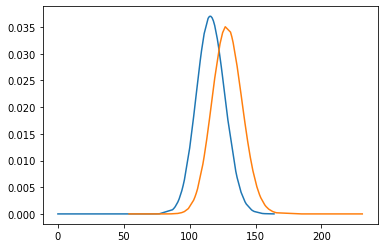

In [133]:
t_home = sorted(score_data[home])
p_home = poisson.pmf(t_home, run_avg[home])
plt.plot(t_home, p_home)
t_away = sorted(score_data[away])
p_away = poisson.pmf(t_away, run_avg[away])
plt.plot(t_away, p_away)
plt.show()

The above chart is nice and similar (makes sense!)

What we'd expect is that multiplying these together, returning our probability matrix, should result in a relatively even distributino - a straight(ish) line. Although since there is a theoretical max score of 720 per innings, we'd expect that our probabilities themselves are quite small (e.g. 148 to 122 should produce a small number!).

Note: due to a limitation in the charting library, the indices are 0-len(indices). In this case, just look up the index of the score to find where that match up is on the matrix. Since we're just using this for demonstration purposes, we aren't too fussed.

Also note that we can only use historical scores of the team and are limited by the youngness of the WBBL (as of this writing the WBBL has only hosted 210 matches, whereas the IPL has hosted 765). When each team has played hundreds of matches we can track the performance of each team much better (and end up with a much bigger matrix!)

In [134]:
prob_table = np.array([(i*j) for i, j in product(p_home, p_away)])
prob_table.shape = (len(p_home), len(p_away))
prob_df = pd.DataFrame(prob_table)

cm = sns.light_palette("blue", as_cmap=True)

prob_df=prob_df.style.background_gradient(cmap=cm)
display(prob_df)


As seen above, our suspicions were correct - matchups between teams are pretty even, and the odds of the score being a blowout are vanishingly small (at least in terms of the total runs scored, not accounting for technical wins e.g. wickets).
